## Ex1: Model Quality vs. Explanation Quality

> **Hypothesis**: "Explanation can only be as good as the model underlying it."

In [149]:
# Standard libraries
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# PyTorch utilities + TorchVision
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# XAI evaluation
import quantus

In [22]:
# Reproducibility
torch.manual_seed(42); np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load `MNIST` dataset

In [23]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST('./data', train=False, download=True, transform=transform)

test_loader   = DataLoader(test_dataset,  batch_size=256, shuffle=False)

### CNN Models
- Shared architecture
- Different training regimes
- Models: Underfit, Overfit, Properly-Trained

In [24]:
class CNNModel(nn.Module):
    """A CNN with two conv layers + dropout. 
       Identical architecture in each regime, but different training setups."""
    def __init__(self, dropout1=0.25, dropout2=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool  = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

def train_model(model, trainloader, optimizer, epochs, device):
    """Train CNN model for image classification (MNIST)."""
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    model.train()
    for epoch in range(epochs):
        correct, total, running_loss = 0, 0, 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_acc = 100.0 * correct / total
        avg_loss = running_loss / len(trainloader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%")

def evaluate_model(model, loader, device):
    """Evaluate trained model on data loader."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total

Generate a subset of 200 samples (for underfit & overfit model training, shared)

In [103]:
gen = torch.Generator().manual_seed(14)
subset_indices = torch.randperm(len(train_dataset), generator=gen)[:200]

### Underfit Model
- 200 training samples
- 1 epoch training
- dropout -> further reduce network complexity

In [104]:
# A) UNDERFIT (few epochs, subset data -> low test acc)
underfit_model = CNNModel(dropout1=0.25, dropout2=0.5)

underfit_loader = DataLoader(
    Subset(train_dataset, subset_indices),
    batch_size=128,
    shuffle=True,
    generator=gen
)

optim_underfit = optim.Adam(underfit_model.parameters(), lr=0.001)

print("--- UNDERFIT MODEL TRAINING ---")
train_model(underfit_model, underfit_loader, optim_underfit, epochs=1, device=device)
underfit_acc = evaluate_model(underfit_model, test_loader, device)
print(f"Underfit Model Test Accuracy: {underfit_acc:.2f}%")

--- UNDERFIT MODEL TRAINING ---
Epoch 1/1 - Loss: 2.2805, Train Acc: 16.00%
Underfit Model Test Accuracy: 28.31%


### Overfit Model
- 200 training samples
- 20 epoch training (much more than proper and underfit)
- no dropout -> higher complexity

In [105]:
# B) OVERFIT (no dropout, many epochs on small subset -> memorizes subset, bigger gap)
overfit_model = CNNModel(dropout1=0.0, dropout2=0.0)

overfit_loader = DataLoader(
    Subset(train_dataset, subset_indices),
    batch_size=128,
    shuffle=True,
    generator=gen
)

optim_overfit = optim.Adam(overfit_model.parameters(), lr=0.001)

print("--- OVERFIT MODEL TRAINING ---")
train_model(overfit_model, overfit_loader, optim_overfit, epochs=20, device=device)
overfit_acc = evaluate_model(overfit_model, test_loader, device)
print(f"Overfit Model Test Accuracy: {overfit_acc:.2f}%")

--- OVERFIT MODEL TRAINING ---
Epoch 1/20 - Loss: 2.2242, Train Acc: 18.50%
Epoch 2/20 - Loss: 1.7624, Train Acc: 44.00%
Epoch 3/20 - Loss: 1.1317, Train Acc: 74.50%
Epoch 4/20 - Loss: 0.6786, Train Acc: 87.50%
Epoch 5/20 - Loss: 0.4921, Train Acc: 88.50%
Epoch 6/20 - Loss: 0.2721, Train Acc: 91.50%
Epoch 7/20 - Loss: 0.2268, Train Acc: 92.00%
Epoch 8/20 - Loss: 0.1630, Train Acc: 93.50%
Epoch 9/20 - Loss: 0.0970, Train Acc: 98.00%
Epoch 10/20 - Loss: 0.0549, Train Acc: 99.00%
Epoch 11/20 - Loss: 0.0531, Train Acc: 99.00%
Epoch 12/20 - Loss: 0.0315, Train Acc: 100.00%
Epoch 13/20 - Loss: 0.0151, Train Acc: 100.00%
Epoch 14/20 - Loss: 0.0131, Train Acc: 100.00%
Epoch 15/20 - Loss: 0.0103, Train Acc: 100.00%
Epoch 16/20 - Loss: 0.0081, Train Acc: 100.00%
Epoch 17/20 - Loss: 0.0047, Train Acc: 100.00%
Epoch 18/20 - Loss: 0.0040, Train Acc: 100.00%
Epoch 19/20 - Loss: 0.0030, Train Acc: 100.00%
Epoch 20/20 - Loss: 0.0021, Train Acc: 100.00%
Overfit Model Test Accuracy: 81.11%


### Properly-Trained Model
- orig. train + test split for mnist: full dataset used
- 8 epoch training
- dropout -> reduce complexity 

In [28]:
# C) PROPER (normal dropout, full dataset, moderate epochs -> high test acc)
proper_model = CNNModel(dropout1=0.25, dropout2=0.25)
proper_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

optim_proper = optim.Adam(proper_model.parameters(), lr=0.001)

print("--- PROPERLY TRAINED MODEL ---")
train_model(proper_model, proper_loader, optim_proper, epochs=8, device=device)
proper_acc = evaluate_model(proper_model, test_loader, device)
print(f"Proper Model Test Accuracy: {proper_acc:.2f}%")

--- PROPERLY TRAINED MODEL ---
Epoch 1/8 - Loss: 0.1808, Train Acc: 94.48%
Epoch 2/8 - Loss: 0.0622, Train Acc: 98.08%
Epoch 3/8 - Loss: 0.0454, Train Acc: 98.60%
Epoch 4/8 - Loss: 0.0359, Train Acc: 98.86%
Epoch 5/8 - Loss: 0.0284, Train Acc: 99.11%
Epoch 6/8 - Loss: 0.0265, Train Acc: 99.15%
Epoch 7/8 - Loss: 0.0220, Train Acc: 99.28%
Epoch 8/8 - Loss: 0.0172, Train Acc: 99.44%
Proper Model Test Accuracy: 99.00%


In [29]:
# Get batch of test images
test_images, test_labels = next(iter(test_loader))

### Qualitative Assessment (visualization)
- (1) Input -- (2) Model output probs -- (3) XAI explanation (saliency)

In [135]:
def visualize_examples(model, model_name, method, image, image_label, device, save_path=None):
    """Visualize model predictions and explanations for a given input image."""
    sns.set(style="white", font_scale=1.1)
    image = image.to(device)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    model.eval()
    with torch.no_grad():
        logits = model(image)
        probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()
        pred_label = int(np.argmax(probs))

    # Get attributions
    attributions = quantus.explain(model, image, pred_label, method=method)

    # -- Symmetric scaling --
    abs_max = np.max(np.abs(attributions))
    # Create symmetric vmin and vmax
    vmin = -abs_max
    vmax = abs_max

    # Plot original image
    axes[0].imshow(image.squeeze().detach().cpu().numpy(), cmap='gray')
    axes[0].set_title(f"True Label: {image_label}", fontsize=18)
    axes[0].axis('off')

    # Plot model output probabilities
    highlight_color = sns.color_palette("Set1")[0]
    base_palette = sns.color_palette("Blues", 10)
    bar_colors = [highlight_color if i == pred_label else base_palette[i] for i in range(10)]
    axes[1].bar(range(10), probs, color=bar_colors)
    axes[1].set_title(f"Prediction: {pred_label} ({probs[pred_label]:.2f})", fontsize=18)
    axes[1].set_xlabel("Class")
    axes[1].set_ylabel("Probability")
    axes[1].set_ylim(0, 1)
    axes[1].set_xticks(range(10))

    # Remove top and right spines
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    # Plot XAI explanation (overlay original image)
    im = axes[2].imshow(attributions.squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
    axes[2].imshow(image.squeeze().detach().cpu().numpy(), cmap='gray_r', alpha=0.3)
    axes[2].set_title("Heatmap", fontsize=18)
    axes[2].axis('off')

    fig.suptitle(f"{model_name}")
    cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    plt.tight_layout()

    if save_path: # If specified, save figure (as pdf)
        plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()

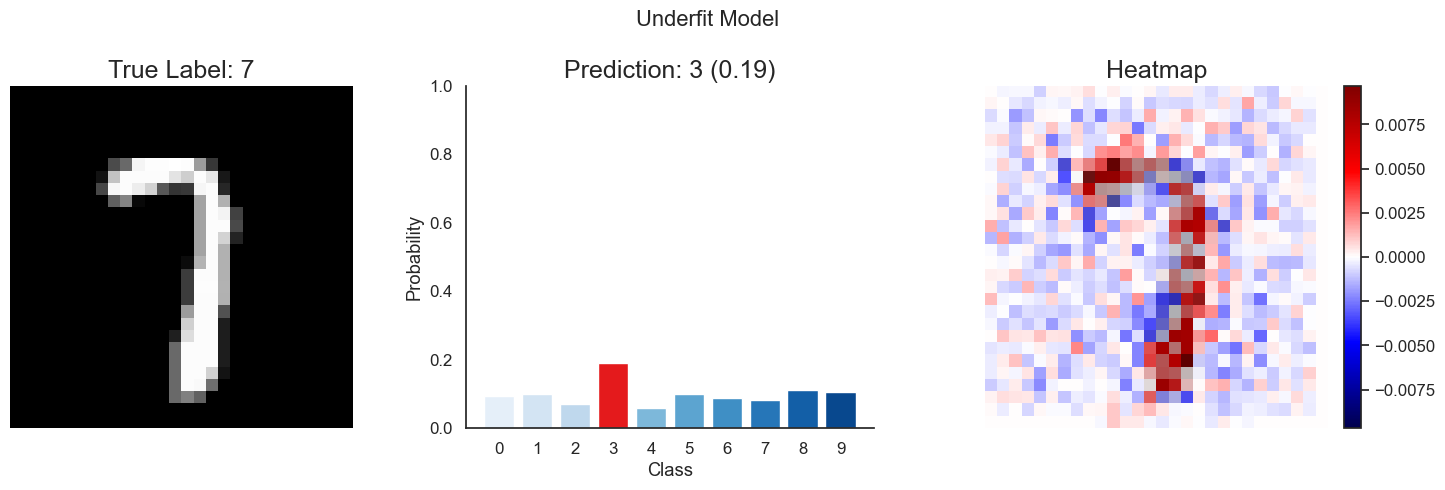

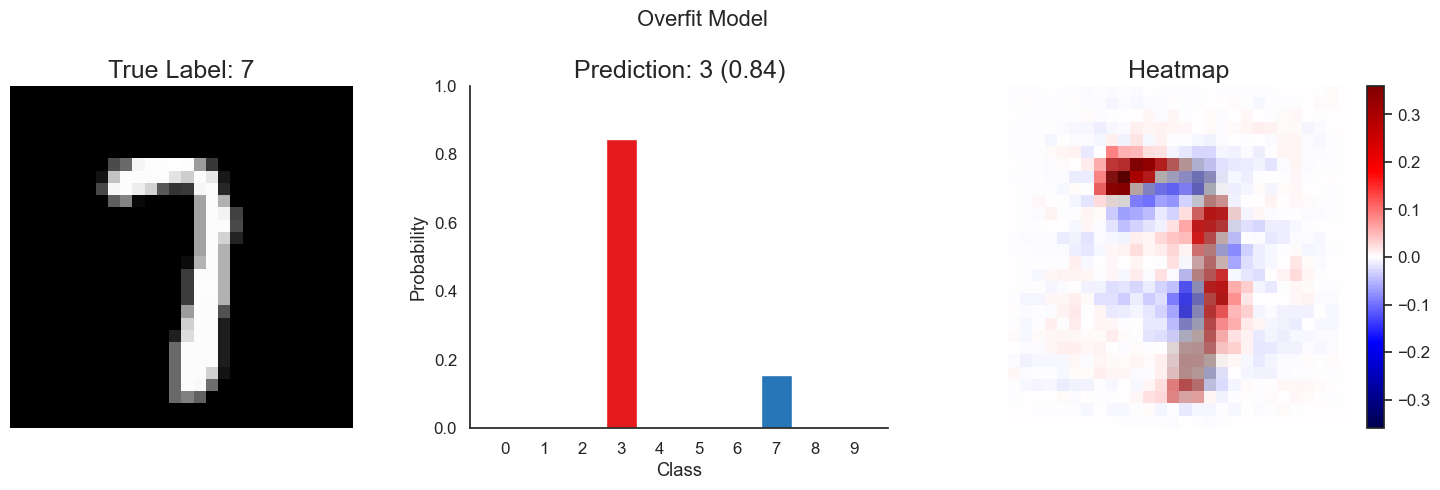

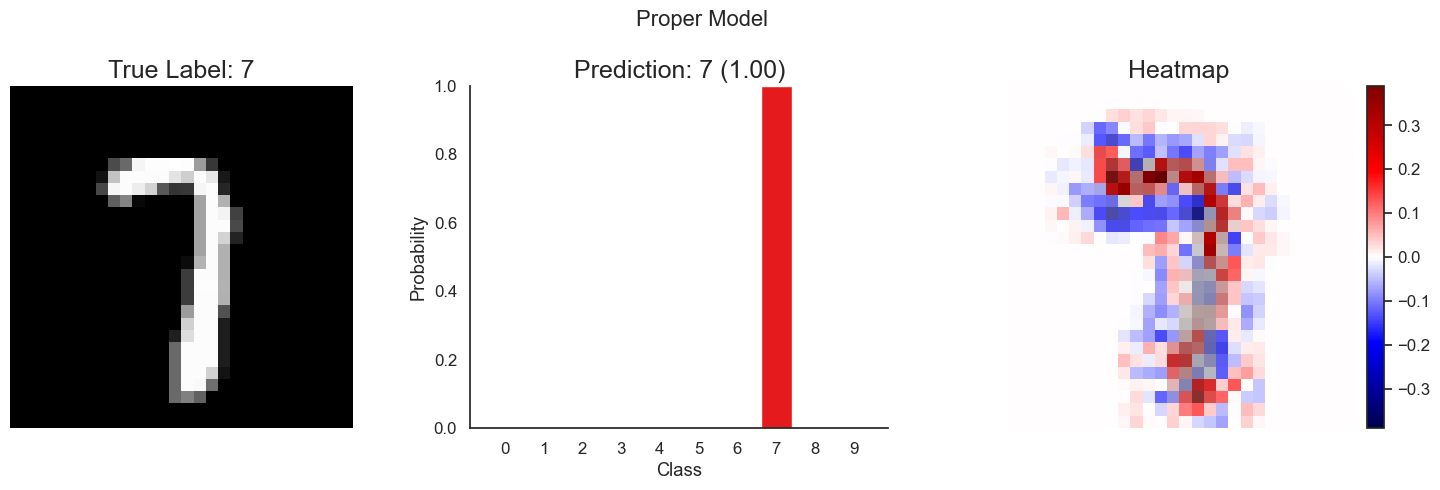

In [136]:
PATH = "./figures"
METHOD = "Gradient" # Vanilla Gradients (Saliency)

idx = 255
image = test_images[idx].unsqueeze(0)
image = image.to(device)
image.requires_grad_(True)

image_label = test_labels[idx]

# Visualize examples
visualize_examples(underfit_model, "Underfit Model", METHOD, image, image_label, device, save_path=f"{PATH}/underfit_gradient.pdf")
visualize_examples(overfit_model,  "Overfit Model",  METHOD, image, image_label, device, save_path=f"{PATH}/overfit_gradient.pdf")
visualize_examples(proper_model,   "Proper Model",   METHOD, image, image_label, device, save_path=f"{PATH}/proper_gradient.pdf")

### Quantitative Assessment (`Quantus`)

Methods selected based on [MetaQuantus](https://arxiv.org/abs/2302.07265), implemented following [Quantus](https://arxiv.org/abs/2202.06861).

In [279]:
metrics = {
    "Robustness": quantus.LocalLipschitzEstimate( # ↓ better
        nr_samples=50,                            # Number of perturbation samples/instance
        abs=True,                                 # So that neg/pos attribs dont cancel
        normalise=True,                           # Each saliency map ~ comparable scale
        perturb_func=quantus.perturb_func.gaussian_noise,
        perturb_mean=0.0,                         # Centered noise
        perturb_std=0.02,                         # Small enough to stay 'local' on MNIST pixel intensities (try 0.1)
        return_nan_when_prediction_changes=True,  # If the model prediction flips, ignore those perturbations
        return_aggregate=True,
    ),
    "Faithfulness": quantus.PixelFlipping(        # ↓ better
        features_in_step=1,
        abs=True,
        normalise=False,                          # Custom normalization
        perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
        perturb_baseline='black',
        return_aggregate=False,
        return_auc_per_sample=True,
    ), 
    "Randomisation": quantus.RandomLogit(         # ↓ better
        num_classes=10,
        #similarity_func=quantus.similarity_func.ssim,
        similarity_func=quantus.similarity_func.cosine,
        abs=True, 
        normalise=True, 
        return_aggregate=True, 
    ),
    "Localisation": quantus.PointingGame(         # ↑ better
        weighted=True,
        abs=False,
        normalise=True,
        return_aggregate=True,
    ),
    "Complexity": quantus.Sparseness(             # ↑ better
        abs=True, 
        normalise=False,
        return_aggregate=True, 
    ),
}

In [280]:
def generate_digit_mask(x):
    """Generate binary segmentation mask for MNIST digits."""
    # undo torchvision normalization
    imgs = ((x * 0.3081) + 0.1307)                      # still float [0,1]
    mask = (imgs > 0.05).cpu().numpy().astype(np.uint8) # threshold at 0.05
    return mask  # shape (B,1,28,28)

In [299]:
def select_confident_correct(x, y, model, device, p_min=0.7):
    """Select samples that model predicts correctly with high confidence."""
    model.eval()
    with torch.no_grad():
        logits = model(x.to(device))
        probs  = torch.softmax(logits, 1).cpu()
        preds  = probs.argmax(1)
    mask = (preds == y) & (probs.max(1).values >= p_min)
    return mask

In [300]:
def prepare_evaluation_data(model, dataset, device, N=1024):
    """Prepare data for evaluating explanation quality."""
    loader = DataLoader(dataset, batch_size=N, shuffle=True)
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    a = quantus.explain(model, x, y.cpu().numpy(), method="Gradient", device=device)
    s = generate_digit_mask(x)
    from scipy.ndimage import binary_dilation
    s = binary_dilation(s, iterations=1)
    # NOTE: try different segmentation mask methods
    # e.g., bbox, edges, skeleton, ...
    # Plot example segmentation mask
    # plt.imshow(s[0,0], cmap='gray')
    # plt.axis('off')
    # plt.show()
    return x.cpu().numpy(), y.cpu().numpy(), s, a.astype(np.float32)

In [314]:
def _eval_faithfulness(model, x, y, metric, device):
    """Evaluate faithfulness of explanations using PixelFlipping metric."""
    # 1) Compute raw logits and predicted-class logits
    x_t = torch.from_numpy(x).to(device)
    with torch.no_grad():
        logits = model(x_t)
    preds = logits.argmax(dim=1)
    start_logits = logits[torch.arange(len(preds)), preds].cpu().numpy()
    # 2) Compute PixelFlipping AUC per sample
    auc_scores = np.array(
        metric(
            model=model,
            x_batch=x,
            y_batch=y,
            explain_func=quantus.explain,
            explain_func_kwargs={"method": "Gradient", "device": device},
            softmax=False,
            device=device
        )
    )
    # 3) Normalize by start logits and average
    eps = 1e-9
    normalized = auc_scores / (start_logits + eps)
    return float(normalized.mean())

In [315]:
def evaluate(model, x, y, s, a, device):
    """Evaluate multiple explainability metrics on model predictions.

    This function evaluates a set of metrics on model predictions, including:
    - Faithfulness: Using pixel flipping to measure explanation quality
    - Robustness & Randomisation: Metrics requiring explainability methods
    - Localisation: Using segmentation masks to evaluate spatial accuracy
    - Other metrics like RRA and Sparseness
    """
    out = {}
    for name, metric in metrics.items():
        print(f"Evaluating {name}...")

        if name == "Faithfulness":
            out[name] = _eval_faithfulness(model, x, y, metric, device)
            continue

        # Base kwargs for most metrics
        kwargs = {
            "model": model,
            "x_batch": x,
            "y_batch": y,
            "device": device
        }

        # Metrics requiring explainability (Robustness, Randomisation)
        if name in {"Robustness", "Randomisation"}:
            kwargs.update({
                "explain_func": quantus.explain,
                "explain_func_kwargs": {"method": METHOD, "device": device},
                "softmax": False
            })
        else: # Other metrics (RRA, Sparseness, Localisation)
            kwargs.update({
                "a_batch": a,
                "s_batch": s if name == "Localisation" else None
            })

        # Extract first element as scalar
        out[name] = float(metric(**kwargs)[0])

    return out

### Main Quantitative Evaluation Loop

**NOTE:** Beware, computationally heavy!

In [340]:
all_results = {}
model_list = [("Underfit", underfit_model), ("Overfit",  overfit_model), ("Proper",   proper_model)]

# ---------- Quantitative Evaluation loop ----------
for tag, model in model_list:      
    print(f"\n── {tag.upper()} MODEL ──")
    x_np, y_np, s_np, a_np = prepare_evaluation_data(model, test_dataset, device, N=100)
    mask = select_confident_correct(torch.tensor(x_np), torch.tensor(y_np), model, device)
    x_np, y_np, s_np, a_np = [arr[mask] for arr in (x_np, y_np, s_np, a_np)]
    
    # Get metric scores
    scores = evaluate(model, x_np, y_np, s_np, a_np, device)
    all_results[tag] = scores


── UNDERFIT MODEL ──
Evaluating Robustness...


c:\Users\simon\Desktop\dp\code\learning\quantus\venv\lib\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


Evaluating Faithfulness...
Evaluating Randomisation...
Evaluating Localisation...
Evaluating Complexity...

── OVERFIT MODEL ──
Evaluating Robustness...
Evaluating Faithfulness...
Evaluating Randomisation...
Evaluating Localisation...
Evaluating Complexity...

── PROPER MODEL ──
Evaluating Robustness...
Evaluating Faithfulness...


c:\Users\simon\Desktop\dp\code\learning\quantus\venv\lib\site-packages\quantus\helpers\warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Evaluating Randomisation...
Evaluating Localisation...
Evaluating Complexity...


In [345]:
results_df = pd.DataFrame(all_results).T
results_df
all_results

{'Underfit': {'Robustness': 2.1379930086316485,
  'Faithfulness': 278.0416713041967,
  'Randomisation': 0.3763749761886063,
  'Localisation': 0.5914723032069971,
  'Complexity': 0.5550870983814865},
 'Overfit': {'Robustness': 0.43536858854373767,
  'Faithfulness': 72.02231309552232,
  'Randomisation': 0.32792629736538864,
  'Localisation': 0.6283443255350922,
  'Complexity': 0.7193497925246457},
 'Proper': {'Robustness': 1.2109527575802645,
  'Faithfulness': 60.10034897948885,
  'Randomisation': 0.29360723521091403,
  'Localisation': 0.6197948876520305,
  'Complexity': 0.7192874079158741}}

In [342]:
# Select metrics and  models
metrics_names = ["Robustness", "Faithfulness", "Localisation", "Complexity", "Randomisation"]
models  = ["Underfit", "Overfit", "Proper"]
invert  = {"Robustness", "Faithfulness", "Randomisation"}  # lower-is-better -> invert

# Raw‐value array (n_models x n_metrics)
arr = np.zeros((len(models), len(metrics_names)))
for i, m in enumerate(models):
    for j, metric in enumerate(metrics_names):
        v = all_results[m][metric]
        arr[i, j] = 1/(1+v) if metric in invert else v

arr

array([[0.31867502, 0.00358369, 0.5914723 , 0.5550871 , 0.72654619],
       [0.69668516, 0.01369444, 0.62834433, 0.71934979, 0.75305384],
       [0.4522937 , 0.01636652, 0.61979489, 0.71928741, 0.77303216]])

In [343]:
# SCALING v2: div by max -> [0,1] (looks better)
maxs = arr.max(axis=0)
arr_scaled_divmax = arr / (maxs + 1e-8)
arr_scaled_divmax

array([[0.45741611, 0.21896483, 0.94131875, 0.77165114, 0.9398654 ],
       [0.99999999, 0.83673482, 0.99999998, 0.99999999, 0.97415589],
       [0.64920816, 0.99999939, 0.98639369, 0.99991326, 0.99999999]])

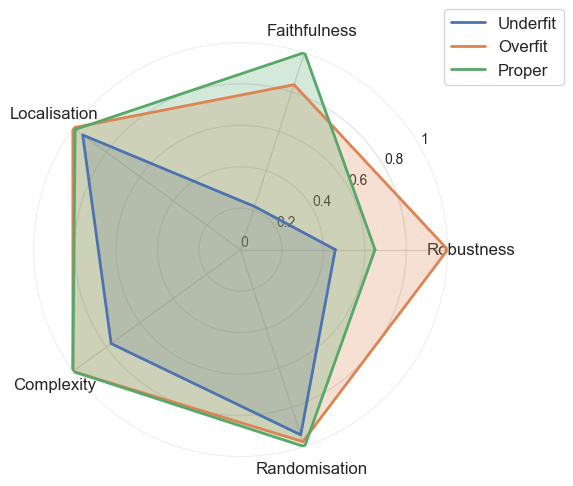

In [344]:
# Radar plot on [0,1] scale
N = len(metrics_names)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

for i, model in enumerate(models):
    arr_scaled = arr_scaled_divmax # or set to 'arr_scaled_minmax'
    data = arr_scaled[i].tolist()
    data += data[:1]
    ax.plot(angles, data, linewidth=2, label=model)
    ax.fill(angles, data, alpha=0.25)

ax.yaxis.grid(True, linestyle='-', alpha=0.5)
ax.xaxis.grid(True, linestyle='-', alpha=0.7)
ax.set_rlabel_position(30) 
ax.set_thetagrids(np.degrees(angles[:-1]), metrics_names)
ax.set_ylim(0, 1)
ax.spines['polar'].set_visible(False)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], fontsize=10)
ax.grid(True)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
#plt.title("Normalized XAI Quality Across Models", y=1.08, fontsize=14)
plt.savefig(f"{PATH}/ex1_radar_plot.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()